In [31]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from matplotlib import pyplot as plt
from numpy import mean
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, auc, f1_score, precision_score,
                             recall_score, roc_auc_score, silhouette_score)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold,
                                     ShuffleSplit, StratifiedShuffleSplit,
                                     cross_val_score)
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime

In [24]:
IMAGES_PATH = ""

In [30]:
def concat_two_df_and_drop_same_column_in_df2(DF1, DF2):
    display(DF1.head(1))
    display(DF2.head(1))
    DF2.drop(DF2.columns[DF2.columns.isin(DF1.columns)],axis=1,inplace=True)
#     DF1.drop(DF1.columns[DF1.columns.isin(DF2.columns)],axis=1,inplace=True)
    result = pd.concat([DF1, DF2], axis=1)
    display(result.head(1))
    return result
def count_list_val(arr):
    values, counts = np.unique(arr, return_counts=True)
    print(values, counts)
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [7]:
four_time = pd.read_csv("../CSV/four_time.csv")
v_value = pd.read_csv("../CSV/v_value.csv")
mic = pd.read_csv("../CSV/mic.csv")
dwt_distance = pd.read_csv("../CSV/sdtw_day_score_df.csv")
smart_meter = pd.read_csv("../smart_meter.csv")

In [8]:
fdi = pd.read_csv("../CSV/FDI.csv")

In [9]:
four_time.shape, v_value.shape, mic.shape, dwt_distance.shape

((2239250, 7), (2239250, 9), (2239250, 4), (2239250, 5))

In [10]:
result = concat_two_df_and_drop_same_column_in_df2(fdi, v_value)
result = concat_two_df_and_drop_same_column_in_df2(result, four_time)
result = concat_two_df_and_drop_same_column_in_df2(result, mic)
result = concat_two_df_and_drop_same_column_in_df2(result, dwt_distance)
result.columns

,MeterID,Day,FDI
0,1236,2009-07-15,1.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,5212,2010-12-31,True,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,overnight,breakfast,daytime,evening
0,1236,2009-07-15,True,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,mic
0,1236,2009-07-15,True,0.624128


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128


,MeterID,Day,FDI,meter_dtw,meter_sdtw
0,1236,2009-07-15,True,2.283294,-68.276715


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic,meter_dtw,meter_sdtw
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128,2.283294,-68.276715


Index(['MeterID', 'Day', 'FDI', 'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2',
       'Cmin1', 'overnight', 'breakfast', 'daytime', 'evening', 'mic',
       'meter_dtw', 'meter_sdtw'],
      dtype='object')

In [11]:
df = result
X = df[['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']]
Y = df[["FDI"]]

partition = 422*8*530
evaluation = 422*1*530
total = 2239250


X_train = X[:partition]
X_val = X[partition:total-evaluation]
X_test = X[total-evaluation: total]
y_train = Y[:partition]
y_val = Y[partition:total-evaluation]
y_test = Y[total-evaluation: total]
# y_train = np.array(Y[:partition]).reshape(-1) 
# y_val = np.array(Y[partition:total-evaluation]).reshape(-1) 
# y_test = np.array(Y[total-evaluation: total]).reshape(-1) 

In [8]:
count_list_val(Y)

[0. 1.] [2127950  111300]


### read smart_meter.csv and preprocess

In [12]:
elec = smart_meter['Electricity']
elec = np.array(elec).reshape(-1, 48)
elec = pd.DataFrame(elec)
print(elec.shape)
display(elec.head(3))

(2239250, 48)


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.13407,0.129562,0.113616,0.18602,0.075942,0.133117,0.062728,0.064174,0.143932,0.142687,...,0.159253,0.154713,0.118059,0.13057,0.118797,0.056694,0.106094,0.08098,0.068501,0.204674
1,0.48300,0.062000,0.035000,0.06800,0.026000,0.013000,0.063000,0.063000,0.013000,0.013000,...,0.138000,0.099000,0.118000,0.16400,0.218000,0.412000,0.253000,0.61000,0.582000,0.292000
2,0.11400,0.041000,0.012000,0.04000,0.067000,0.017000,0.012000,0.064000,0.058000,0.012000,...,0.110000,0.104000,0.164000,0.40100,0.104000,0.138000,0.206000,0.36300,0.526000,0.326000


In [13]:
result_all= concat_two_df_and_drop_same_column_in_df2(result, elec)
result_all.columns = result_all.columns.astype(str)

,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic,meter_dtw,meter_sdtw
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128,2.283294,-68.276715


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.13407,0.129562,0.113616,0.18602,0.075942,0.133117,0.062728,0.064174,0.143932,0.142687,...,0.159253,0.154713,0.118059,0.13057,0.118797,0.056694,0.106094,0.08098,0.068501,0.204674


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,...,38,39,40,41,42,43,44,45,46,47
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,...,0.159253,0.154713,0.118059,0.13057,0.118797,0.056694,0.106094,0.08098,0.068501,0.204674


## Start Model Training 

In [11]:
result["FDI"] = result["FDI"].astype(int)

In [14]:
partition = 422*8*530
evaluation = 422*1*530
total = 2239250

X_train = X[:partition+evaluation]
y_train = Y[:partition+evaluation]
X_val = result.drop(['Day', 'MeterID', 'FDI'], axis=1)[partition:]
y_val = result['FDI'][partition:]

In [25]:
def train_model(df, x_col, y_col, score = False, split_num = 3, return_model=False ):
    
    X = df[x_col]
    Y = df[y_col]

    partition = 422*8*530
    evaluation = 422*1*530
    total = 2239250

    round = 1
    average_score = {}
    average_score["precision_score"] = 0
    average_score["recall_score"] = 0
    average_score["accuracy_score"] = 0
    average_score["roc_auc_score"] = 0
    average_score["f1_score"] = 0

    X_train = X[:partition+evaluation]
    y_train = Y[:partition+evaluation]

    sss = StratifiedShuffleSplit(n_splits=split_num, test_size=0.4, random_state=1)
    for train_index, test_index in sss.split(X_train, y_train):
#         test_index = np.concatenate((np.array(test_index), np.array(X[total-(partition+evaluation): total].index)))
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = np.array(Y.iloc[train_index]).reshape(-1) , np.array(Y.iloc[test_index]).reshape(-1)

        model = RandomForestClassifier()
        model.fit(X_train, Y_train)
        y_hat = model.predict(X_test)
        average_score["precision_score"] += precision_score(Y_test, y_hat)
        average_score["recall_score"] += recall_score(Y_test, y_hat)
        average_score["accuracy_score"] += accuracy_score(Y_test, y_hat)
        average_score["roc_auc_score"] += roc_auc_score(Y_test, y_hat)
        average_score["f1_score"] += f1_score(Y_test, y_hat)

        if score:
            print("round: " + str(round))
            print("precision score: " + str(precision_score(Y_test, y_hat)))
            print("recall_score: " + str(recall_score(Y_test, y_hat)))
            print("accuracy_score: " + str(accuracy_score(Y_test, y_hat)))
            print("roc_auc_score: " + str(roc_auc_score(Y_test, y_hat)))
            print("f1_score: " + str(f1_score(Y_test, y_hat)))
            print()

        round += 1
    for key, score in average_score.items():
        average_score[key] = score / split_num
        print("average_" + key + ": " + str(average_score[key]))
    if return_model==True:
        return model, average_score
    return average_score

def get_permutation_importance(model, X_val, y_val, title=None, origin=False, save=False):
    
    if save_fig == True and title == None:
        raise NameError('Please type the title for the chart to save')
        
    r = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0)
    four_time_importance = sum(r.importances_mean[:3])
    mic_importance = r.importances_mean[10]
    v_value_importance = sum(r.importances_mean[4:10])
    dtw_importance = r.importances_mean[11]
    sdtw_importance = r.importances_mean[12]
    if origin == True:
        print('include origin data')
        origin_importance = sum(r.importances_mean[13:])
        importance = { "four_time": four_time_importance, "mic": mic_importance, "v_value": v_value_importance,
                  "dtw": dtw_importance, "sdtw": sdtw_importance, 'origin':origin_importance}
    else:
        print('no origin data')
        importance = { "four_time": four_time_importance, "mic": mic_importance, "v_value": v_value_importance, "dtw": dtw_importance, "sdtw": sdtw_importance}
    
    importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))
    
    y_label = list(importance.keys())
    y_pos = np.arange(len(importance))

    plt.rcdefaults()
    fig, ax = plt.subplots()

    ax.barh(y_pos, list(importance.values()), align='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_label)

    ax.set_xlabel('Importance Mean')
    ax.set_title('Permutation importance')
    
    if save == True:
        save_fig('Permutation importance: '+ title)
        
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, image_path = IMAGES_PATH):
    path = os.path.join(image_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [26]:
def plot_importance(importance):
    importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))
    
    y_label = list(importance.keys())
    y_pos = np.arange(len(importance))

    plt.rcdefaults()
    fig, ax = plt.subplots()

    ax.barh(y_pos, list(importance.values()), align='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_label)

    ax.set_xlabel('Importance Mean')
    ax.set_title('Permutation importance')
def save_importance(importance, title, size=(10,10)):
    y_label = list(importance.keys())
    y_pos = np.arange(len(importance))
    
    
    plt.rcdefaults()
#     fig, ax = plt.subplots()
    plt.figure(dpi=150, figsize=size)
    plt.barh(y_pos, list(importance.values()), align='center')

#     ax.set_yticks(y_pos)
#     ax.set_yticklabels(y_label)
    plt.yticks(y_pos, y_label)
    plt.xlabel('Importance Mean')
#     ax.set_xlabel('Importance Mean')
#     ax.set_title('Permutation importance')
    plt.title('Permutation importance')

    save_fig('Permutation importance: '+ title)
def cal_importance_dict():
    importance_dict = {r}
    for index, key in zip(range(len(col)), col):
        print(f'{key}: ', r.importances[index], r.importances_mean[index])
        importance_dict[key] = r.importances_mean[index]
    return importance_dict

## 48 features

In [20]:
TITLE = "Random Forest: 48 features with 0.4 test data"
col = elec.columns.astype(str)
model, score = train_model(result_all, col, ['FDI'], return_model=True)

average_precision_score: 0.957773362649328
average_recall_score: 0.18615853049815315
average_accuracy_score: 0.9590921736365714
average_roc_auc_score: 0.5928642629226076
average_f1_score: 0.31172077981599194


0:  [0.00238383 0.00235302 0.00240304] 0.0023799635294555386
1:  [0.00234498 0.00236508 0.00235927] 0.0023564437497674007
2:  [0.00249012 0.002512   0.00251825] 0.00250679170853337
3:  [0.00305057 0.0030671  0.00307156] 0.0030630791559673742
4:  [0.00534018 0.00540895 0.00535894] 0.005369357299691087
5:  [0.00602568 0.00612928 0.00605426] 0.006069740612556274
6:  [0.0066692  0.00667322 0.00663615] 0.006659521417141101
7:  [0.00738194 0.00740025 0.00735023] 0.007377470135089863
8:  [0.00798616 0.00798973 0.00799598] 0.00799062185999777
9:  [0.00788389 0.00797142 0.00786335] 0.007906218599977644
10:  [0.0074056  0.00740694 0.00744267] 0.007418406460496407
11:  [0.0070671  0.00708809 0.00704477] 0.007066651780730145
12:  [0.00518968 0.00521827 0.00521291] 0.005206951732350862
13:  [0.00367489 0.00371464 0.0036079 ] 0.0036658107253172423
14:  [0.00266473 0.00268304 0.00265759] 0.0026684529790480527
15:  [0.00283041 0.00284917 0.0028121 ] 0.002830560827658054
16:  [0.00240616 0.00242179 0.0

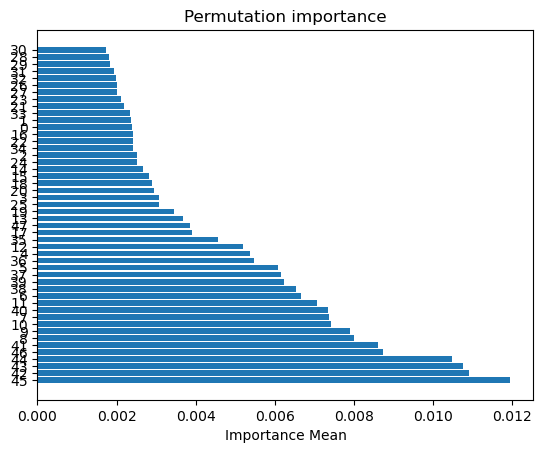

In [21]:
r = permutation_importance(model, result_all[col], result_all['FDI'], n_repeats=3, random_state=0, n_jobs=-1)
importance_dict = {}
for index, key in zip(range(len(col)), col):
    print(f'{key}: ', r.importances[index], r.importances_mean[index])
    importance_dict[key] = r.importances_mean[index]
plot_importance(importance_dict)

Saving figure Permutation importance: RandomForest with 48 features


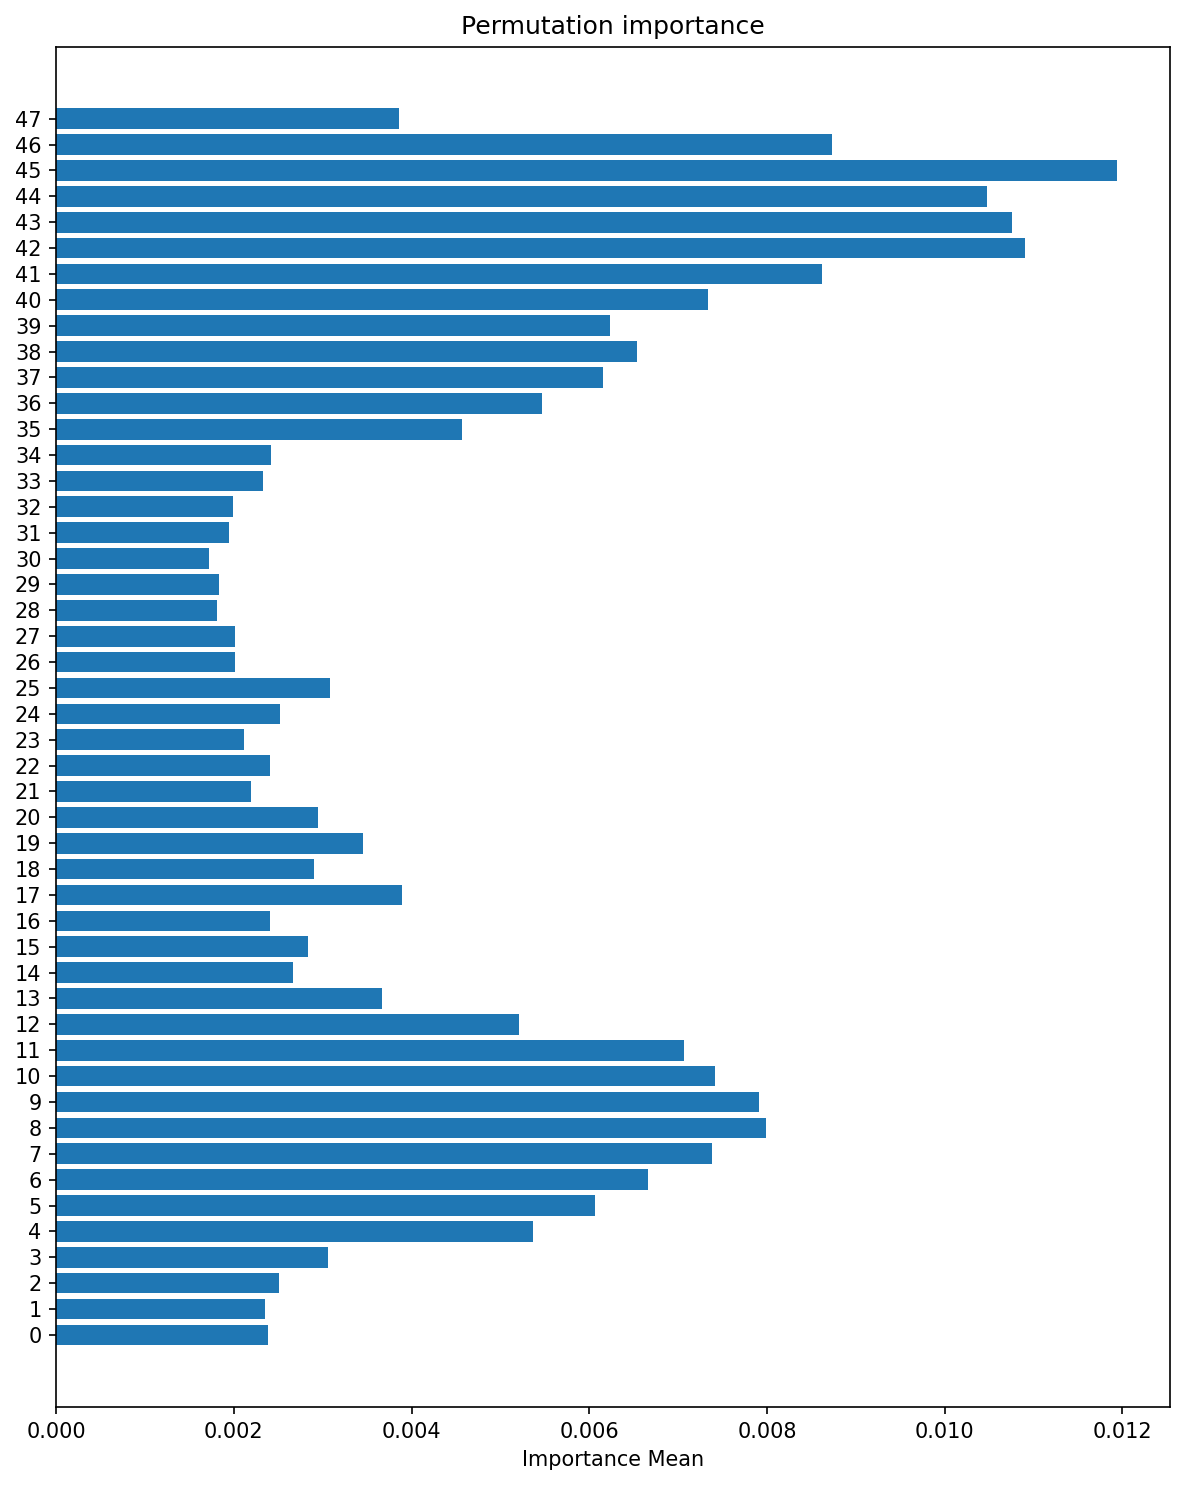

In [27]:
save_importance(importance_dict, "RandomForest with 48 features", size=(8,10))

## 13+48 features

In [34]:
# 6:4 and seperate train and test dataset
# 13 + 48 features
TITLE = "XGBoost: 13+48 features with 0.4 test data"
col = result_all.drop(['Day', 'MeterID', 'FDI'], axis=1).columns
model, score = train_model(result_all, col, ['FDI'], return_model=True)

average_precision_score: 0.9741507552127491
average_recall_score: 0.32760141093474426
average_accuracy_score: 0.9661067890746867
average_roc_auc_score: 0.6635730687590033
average_f1_score: 0.4903088737996926


Tmax1:  [0.00042782 0.00043095 0.00042157] 0.0004267797997841531
Tmax2:  [0.00034744 0.00034431 0.00033985] 0.0003438651334152591
Tmin1:  [0.00038674 0.00040237 0.00038227] 0.0003904581146961794
Cmax1:  [0.01399665 0.01386268 0.01384437] 0.013901231811246325
Cmax2:  [0.01556414 0.01557441 0.01553913] 0.015559227419895091
Cmin1:  [0.01485989 0.01489517 0.01487194] 0.014875665215287862
overnight:  [0.0115695  0.01150608 0.01154449] 0.011540024561795295
breakfast:  [0.00069622 0.00068282 0.00067255] 0.0006838599233374895
daytime:  [0.0025839  0.00263749 0.00255755] 0.002592981280934844
evening:  [0.00626326 0.00623378 0.0062378 ] 0.006244948085296446
mic:  [0.01444725 0.01435927 0.01437088] 0.014392467716125198
meter_dtw:  [0.00998236 0.00986446 0.00989617] 0.009914331435376456
meter_sdtw:  [0.00459172 0.00458546 0.00458234] 0.004586505898552325
0:  [0.00071408 0.00073685 0.0007181 ] 0.0007230099363626877
1:  [0.00066763 0.00064173 0.00063995] 0.0006497711287261435
2:  [0.00077169 0.00075

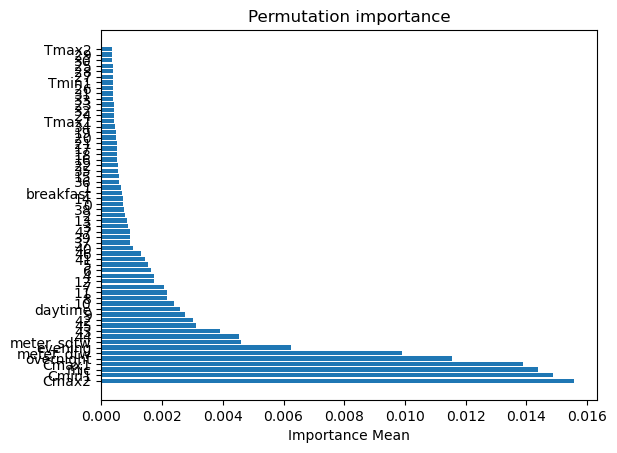

In [35]:
r = permutation_importance(model, result_all[col], result['FDI'], n_repeats=3, random_state=0, n_jobs=-1)
importance_dict = {}
for index, key in zip(range(len(col)), col):
    print(f'{key}: ', r.importances[index], r.importances_mean[index])
    importance_dict[key] = r.importances_mean[index]
plot_importance(importance_dict)

In [40]:
importance_dict

{'Cmax2': 0.015559227419895091,
 'Cmin1': 0.014875665215287862,
 'mic': 0.014392467716125198,
 'Cmax1': 0.013901231811246325,
 'overnight': 0.011540024561795295,
 'meter_dtw': 0.009914331435376456,
 'evening': 0.006244948085296446,
 'meter_sdtw': 0.004586505898552325,
 '44': 0.004523240668378614,
 '43': 0.0039041345688661058,
 '45': 0.0031250046518552046,
 '42': 0.003020207658814389,
 '9': 0.0027434780990659435,
 'daytime': 0.002592981280934844,
 '10': 0.002377432920248612,
 '8': 0.0021480406386066666,
 '11': 0.0021467009043206753,
 '7': 0.002060362472554108,
 '12': 0.0017483532432734557,
 '4': 0.001734955900413097,
 '6': 0.0016384950318187135,
 '5': 0.0015518588813219214,
 '41': 0.0014391723419299913,
 '46': 0.0013177030999963109,
 '40': 0.0010586878046965342,
 '37': 0.0009576122957835794,
 '39': 0.0009488295932417919,
 '47': 0.0009407911875256211,
 '3': 0.0008709761452867504,
 '13': 0.0008416508503591436,
 '2': 0.0007660302928808038,
 '38': 0.0007300063265230546,
 '0': 0.000723009936

Saving figure Permutation importance: RandomForest with 48 + 13 features


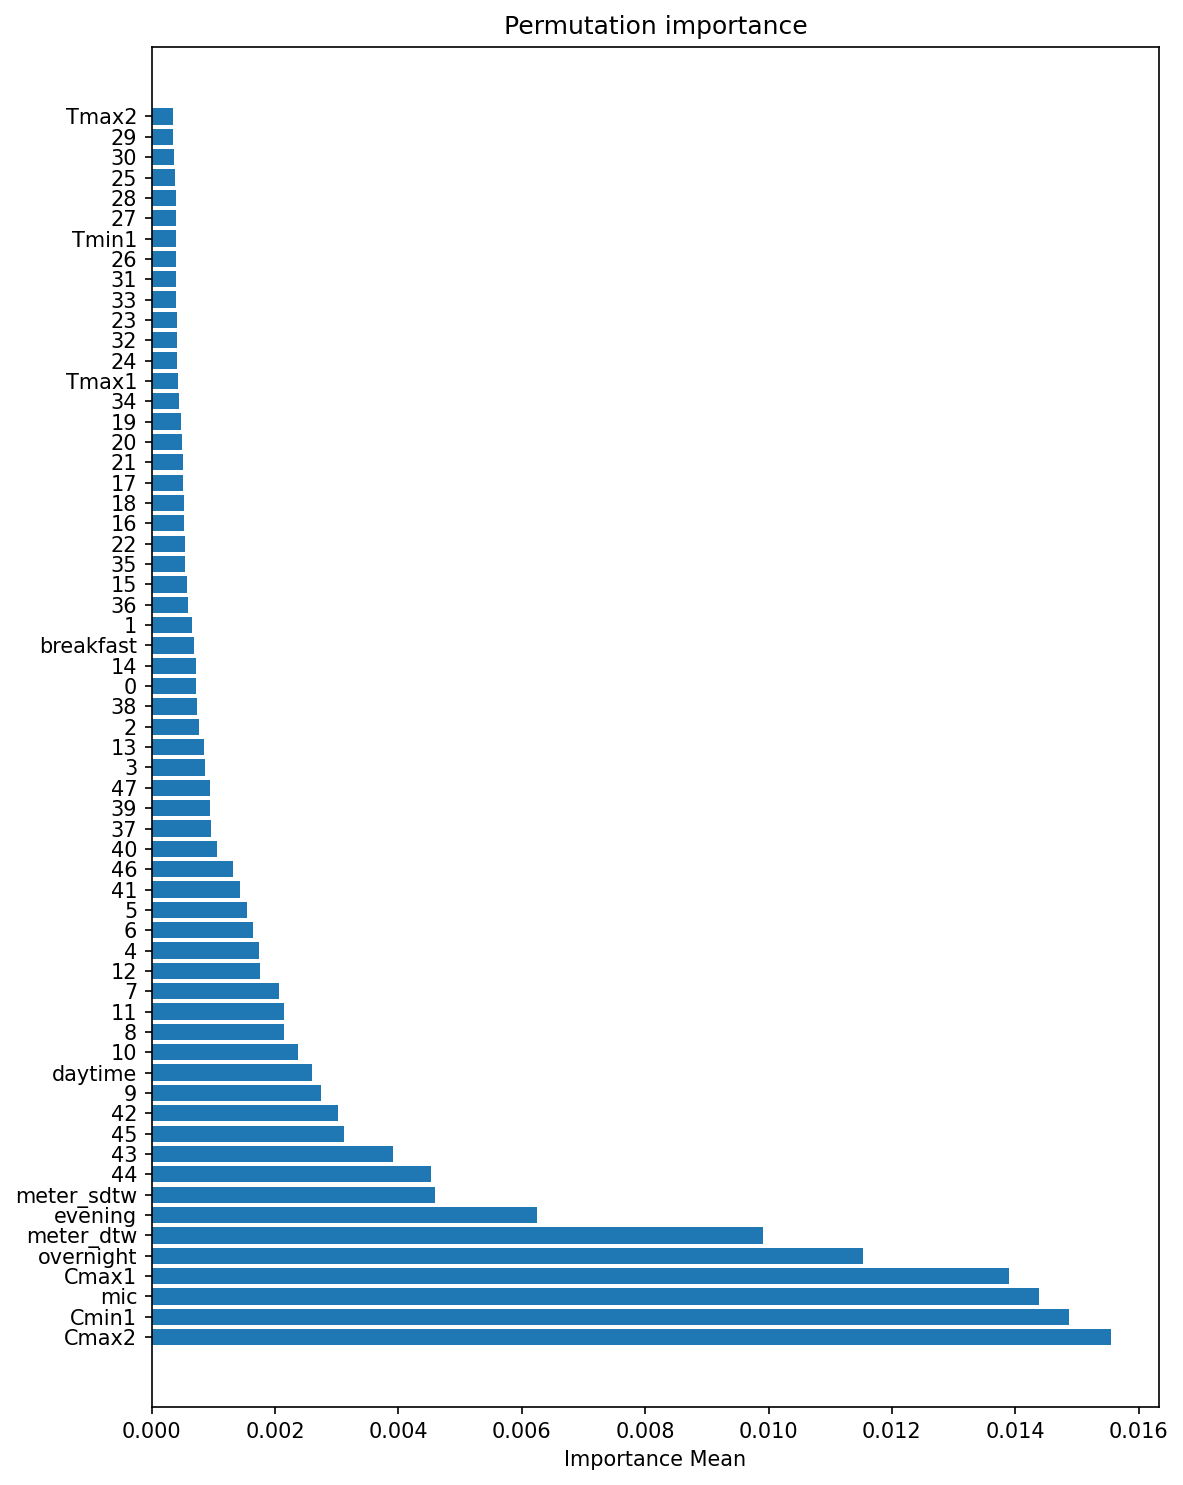

In [38]:
importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
save_importance(importance_dict, "RandomForest with 48 + 13 features", size=(8,10))

## 13 features

average_precision_score: 0.9455557346504229
average_recall_score: 0.3440068550131443
average_accuracy_score: 0.9663700855465139
average_roc_auc_score: 0.6714847643461644
average_f1_score: 0.5044766503161048

 Time taken: 0 hours 41 minutes and 40.14 seconds.
overnight:  [0.01401898 0.01407659 0.01404042] 0.014045327676677433
breakfast:  [0.01525645 0.01517874 0.01524841] 0.015227866473149443
daytime:  [0.01476209 0.01473797 0.01470448] 0.014734844255889223
evening:  [0.01931852 0.01930602 0.01932745] 0.019317330951583462
Tmax1:  [0.00715909 0.0071841  0.00717294] 0.0071720442112313725
Tmax2:  [0.00625924 0.0062253  0.00622664] 0.006237058538945295
Tmin1:  [0.00616054 0.00622887 0.00615787] 0.006182427151948167
Cmax1:  [0.02017461 0.02010673 0.02009423] 0.02012519072606152
Cmax2:  [0.02088378 0.02084448 0.0208226 ] 0.020850284693535708
Cmin1:  [0.02446042 0.02451267 0.02450642] 0.024493171076625336
mic:  [0.01754069 0.01744066 0.01745808] 0.01747981094860625
meter_dtw:  [0.01662834 0.01

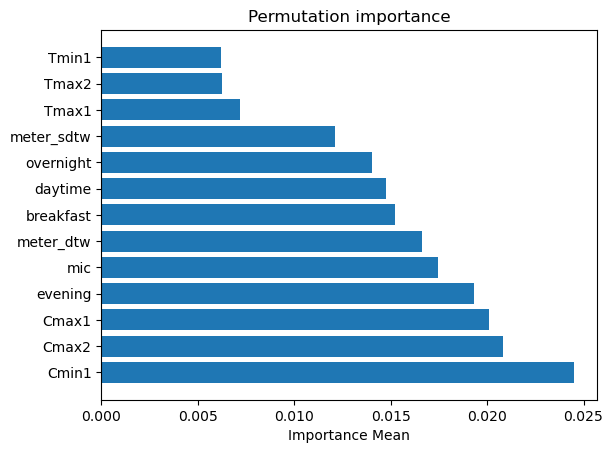

In [41]:
# 6:4 and seperate train and test dataset
# 13 features
TITLE = "XGBoost: 13 features with 0.4 test data"
col = ['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']
start_time = timer(None)
model, score = train_model(result, col, ['FDI'], return_model=True)
timer(start_time)

r = permutation_importance(model, result[col], result['FDI'], n_repeats=3, random_state=0, n_jobs=-1)
importance_dict = {}
for index, key in zip(range(len(col)), col):
    print(f'{key}: ', r.importances[index], r.importances_mean[index])
    importance_dict[key] = r.importances_mean[index]
plot_importance(importance_dict)

Saving figure Permutation importance: RandomForest with 13 features


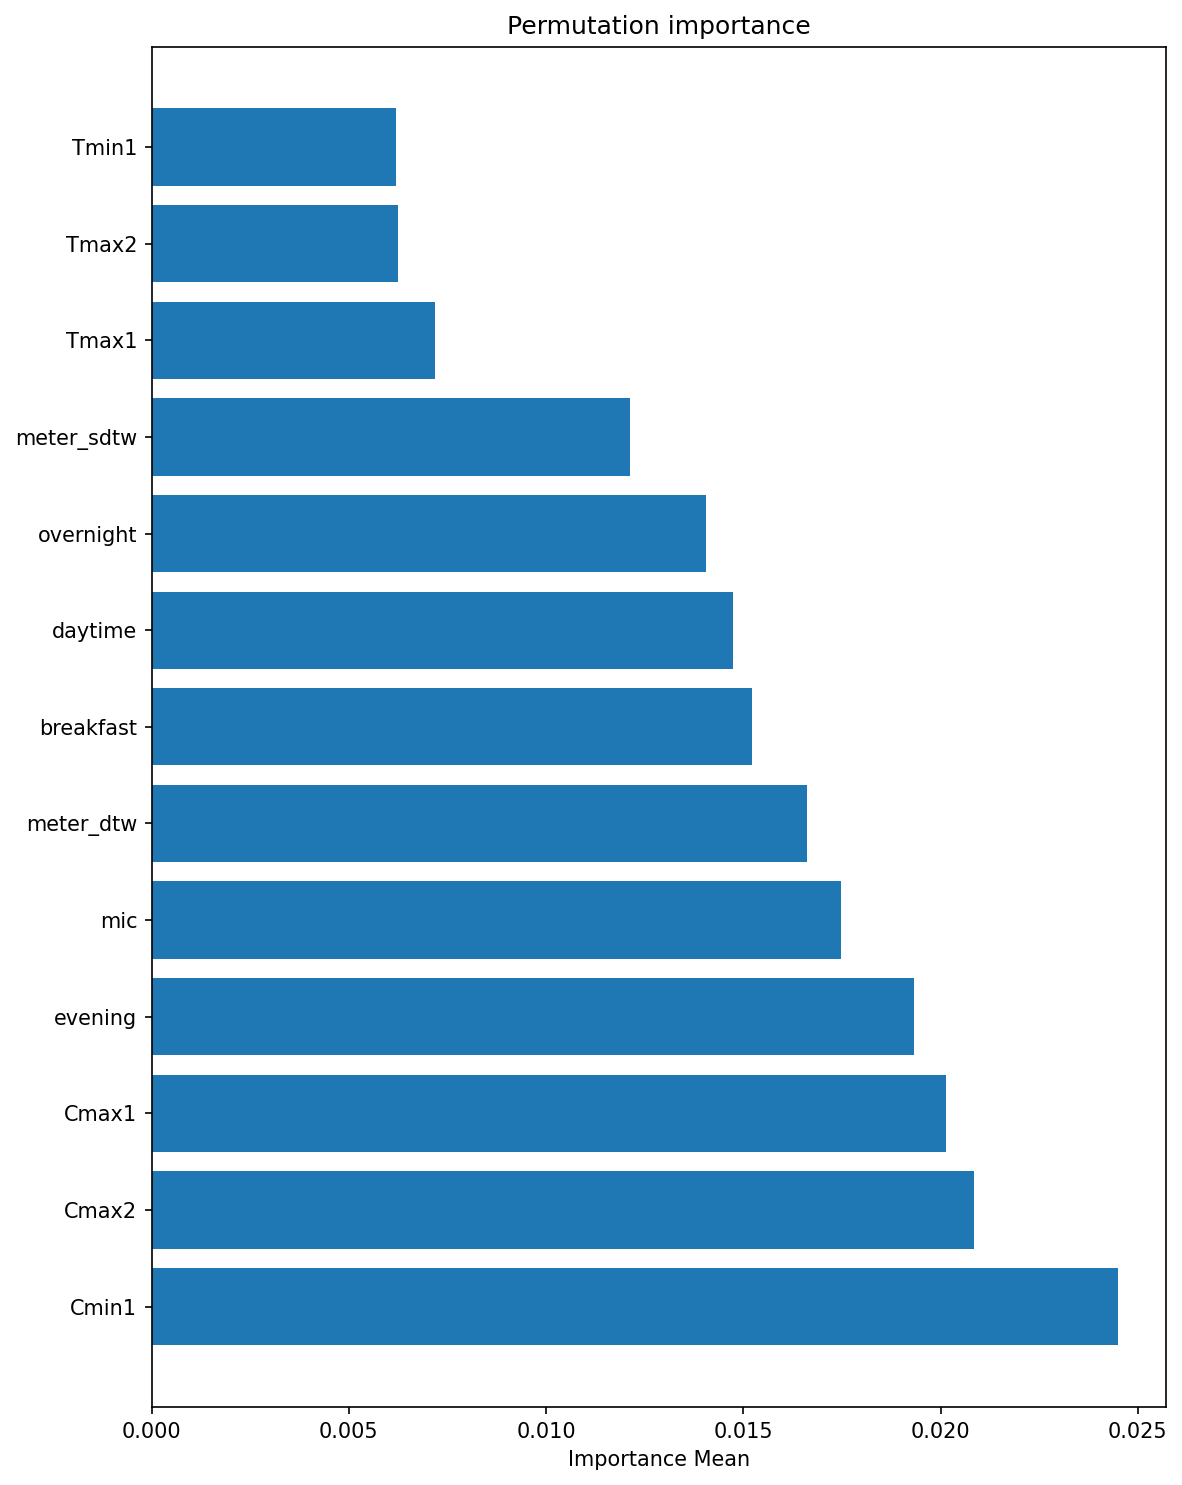

In [42]:
importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
save_importance(importance_dict, "RandomForest with 13 features", size=(8,10))

## each features

In [43]:
# 6:4 and seperate train and test dataset
# Train 4 class of labels
classes = [['meter_dtw', 'meter_sdtw'], ['Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1'], ['overnight', 'breakfast', 'daytime', 'evening'], ['mic']]
for col in classes:
    model, score = train_model(result, col, ['FDI'], return_model=True)

average_precision_score: 0.15232915044662942
average_recall_score: 0.007736847359488868
average_accuracy_score: 0.9484808290361362
average_roc_auc_score: 0.5027417853489466
average_f1_score: 0.014725042411600149
average_precision_score: 0.8386212841496358
average_recall_score: 0.2619047619047619
average_accuracy_score: 0.9607622018871237
average_roc_auc_score: 0.6296327415463537
average_f1_score: 0.39915212624028956
average_precision_score: 0.793511565611645
average_recall_score: 0.16074340288176767
average_accuracy_score: 0.9561545136301463
average_roc_auc_score: 0.5792764312306652
average_f1_score: 0.2673311613228639
average_precision_score: 0.9395323145768505
average_recall_score: 0.5020631592958636
average_accuracy_score: 0.9736132224507438
average_roc_auc_score: 0.7501855117289801
average_f1_score: 0.6544199942017114


average_precision_score: 0.9458649923273722
average_recall_score: 0.3436990449569066
average_accuracy_score: 0.9663613917950857
average_roc_auc_score: 0.6713343446647765
average_f1_score: 0.5041856266189774
no origin data
Saving figure Permutation importance: Random Forest: 13 features with 0.4 test data


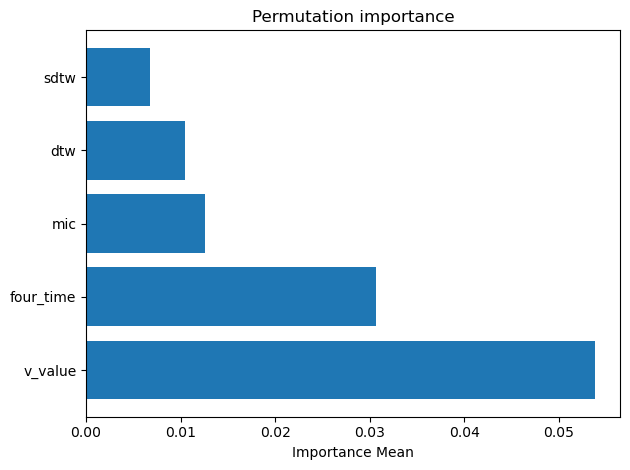

In [13]:
# 6:4 and seperate train and test dataset
# 13 features
TITLE = "Random Forest: 13 features with 0.4 test data"
col = ['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']
model, score = train_model(result, col, ['FDI'], return_model=True)
# get_permutation_importance(model, result[col][partition:], result['FDI'][partition:], title= TITLE, save=True)

In [ ]:
# 6:4 and seperate train and test dataset
# 13 + 48 features
TITLE = "Random Forest: 13 + 48 features with 0.4 test data"
col = result.drop(['Day', 'MeterID', 'FDI'], axis=1).columns
model, score = train_model(result, col, ['FDI'], return_model=True)
get_permutation_importance(model, result[col][partition:], result['FDI'][partition:], title= TITLE, origin=True, save=True)

## old (all meter is false)

average_precision_score: 0.9454552396916549
average_recall_score: 0.18457788426341884
average_accuracy_score: 0.9177844347074428
average_roc_auc_score: 0.5917004688520743
average_f1_score: 0.3088584287084736
no origin data
Saving figure Permutation importance: Random Forest: 13 features with 0.4 test data


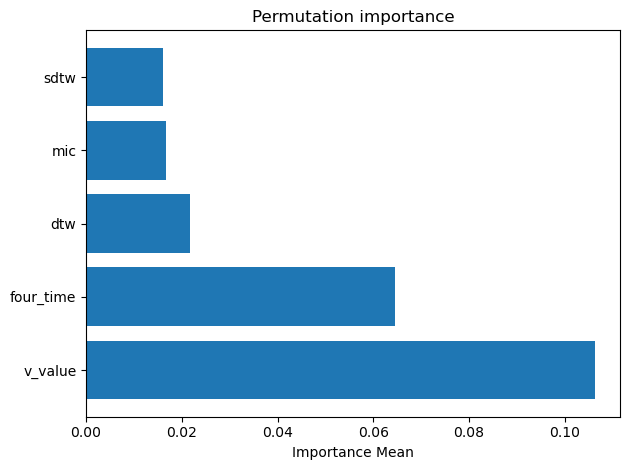

In [14]:
# 6:4 and seperate train and test dataset
# 13 features
TITLE = "Random Forest: 13 features with 0.4 test data"
col = ['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']
model, score = train_model(result, col, ['FDI'], return_model=True)
get_permutation_importance(model, result[col][partition:], result['FDI'][partition:], title= TITLE, save=True)

average_precision_score: 0.9743877184923467
average_recall_score: 0.17453246148214704
average_accuracy_score: 0.9173878340470489
average_roc_auc_score: 0.5870126815116057
average_f1_score: 0.29603783062635547
include origin data
Saving figure Permutation importance: Random Forest: 13 + 48 features with 0.4 test data


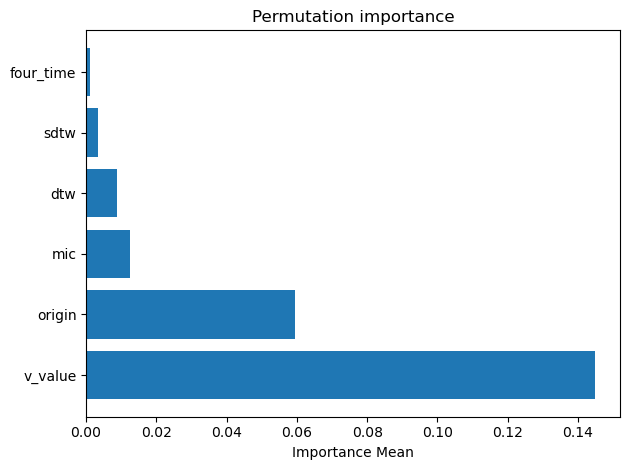

In [14]:
# 6:4 and seperate train and test dataset
# 13 + 48 features
TITLE = "Random Forest: 13 + 48 features with 0.4 test data"
col = result.drop(['Day', 'MeterID', 'FDI'], axis=1).columns
model, score = train_model(result, col, ['FDI'], return_model=True)
get_permutation_importance(model, result[col][partition:], result['FDI'][partition:], title= TITLE, origin=True, save=True)

In [ ]:
model, score